In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
%run ../Task_4/cardiac_ml_tools.py

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Reading In The Data

In [3]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../../cardiac_challenge/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)

In [4]:
num_timesteps = 500

In [5]:
all_pECG_data = np.empty(shape=(len(file_pairs), num_timesteps, 12))
all_Vm_data = np.empty(shape=(len(file_pairs), num_timesteps, 75))
for index,(pecg, vm) in enumerate(file_pairs):
    print("pecg", pecg)
    print("vm", vm)
    all_Vm_data[index] = np.load(vm)
    all_pECG_data[index] = get_standard_leads(np.load(pecg))

pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v2.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pat

# Normalizing The Data

In [6]:
# Getting the range of the data
print("Maximum value in the whole array:%d"%(all_pECG_data.max()))                    
print("Maximum value in the whole array:%d"%(all_pECG_data.min()))                    
print("Maximum value in the whole array:%d"%(all_Vm_data.max()))                    
print("Maximum value in the whole array:%d"%(all_Vm_data.min()))                    

Maximum value in the whole array:5
Maximum value in the whole array:-5
Maximum value in the whole array:49
Maximum value in the whole array:-93



We can see that 
* pECG Data is between -5 and 5
* Vm Data is between -93 and 49

In [7]:
# all_pECG_data = (all_pECG_data + 5) / 10
# all_Vm_data = (all_Vm_data + 100) / 150

# Splitting The Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(all_pECG_data, all_Vm_data, test_size = 0.20, random_state = 0)

# Defining The Model

In [9]:
import tensorflow as tf
from tensorflow import keras


In [10]:

def create_model():
    input_layer = keras.layers.Input(shape=(500, 12))

    lstm1 = keras.layers.LSTM(units=12,return_sequences=True)(input_layer)
    
    lstm2 = keras.layers.LSTM(units=75,return_sequences=True)(lstm1)

    output_layer = keras.layers.Dense(units=75)(lstm2)

    model = keras.Model(input_layer, output_layer)
    
    return model

model = create_model()
display(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 12)]         0         
                                                                 
 lstm (LSTM)                 (None, 500, 12)           1200      
                                                                 
 lstm_1 (LSTM)               (None, 500, 75)           26400     
                                                                 
 dense (Dense)               (None, 500, 75)           5700      
                                                                 
Total params: 33,300
Trainable params: 33,300
Non-trainable params: 0
_________________________________________________________________


None

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="sgd",
    loss="mean_squared_error",
    metrics=["accuracy"],
)

epochs = 100
batch_size = 32

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    verbose=1,
)

Epoch 1/100


2023-07-26 17:27:17.876431: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


403/403 [==============================] - 38s 88ms/step - loss: 2334.4775 - accuracy: 0.0353 - val_loss: 2270.6821 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 2/100
403/403 [==============================] - 30s 73ms/step - loss: 2267.1941 - accuracy: 0.0365 - val_loss: 2268.7937 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 3/100
403/403 [==============================] - 30s 73ms/step - loss: 2265.8638 - accuracy: 0.0365 - val_loss: 2267.8171 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 4/100
403/403 [==============================] - 30s 73ms/step - loss: 2265.0923 - accuracy: 0.0365 - val_loss: 2267.1902 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 5/100
403/403 [==============================] - 30s 73ms/step - loss: 2264.5549 - accuracy: 0.0365 - val_loss: 2266.7268 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 6/100
403/403 [==============================] - 29s 73ms/step - loss: 2264.1389 - accuracy: 0.0365 - val_loss: 2266.3518 - val_accuracy: 0.0397 - lr: 0.0100
Epoch 7/100
403/403 [=======

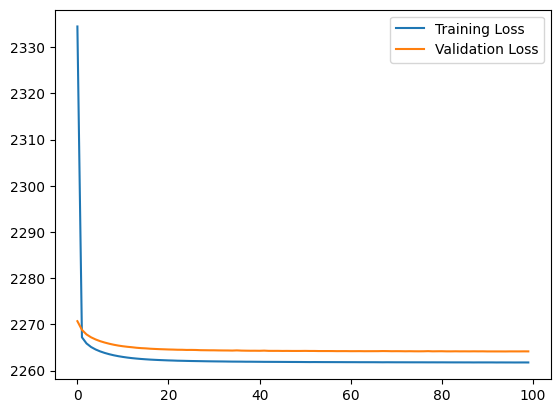

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

75


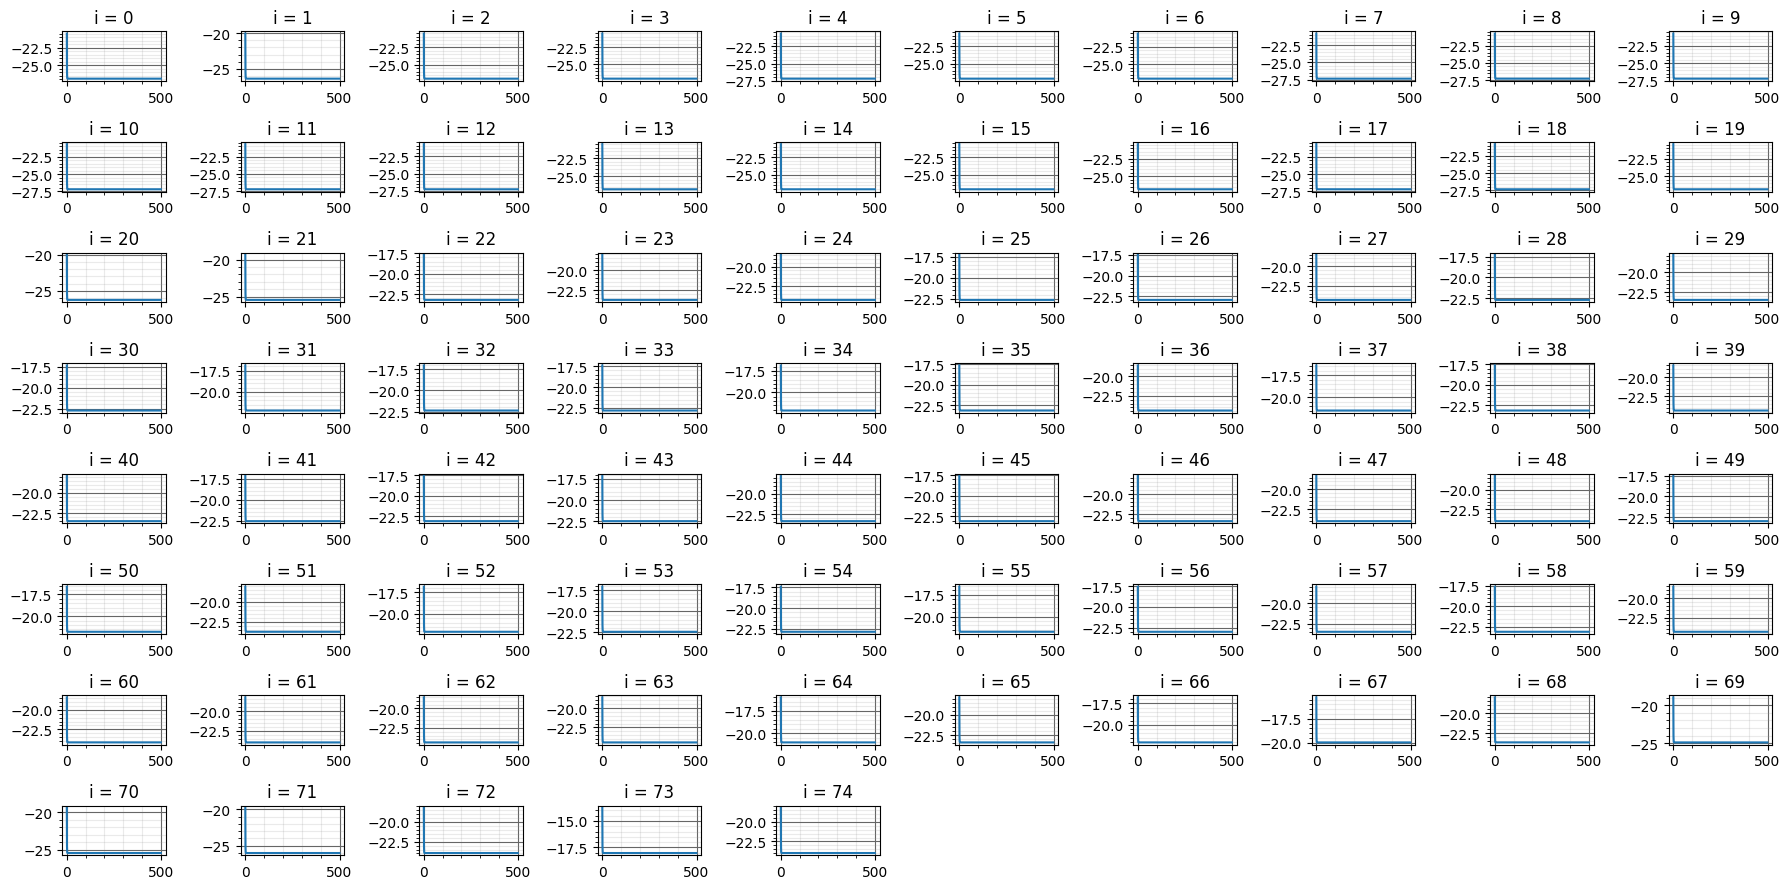

75


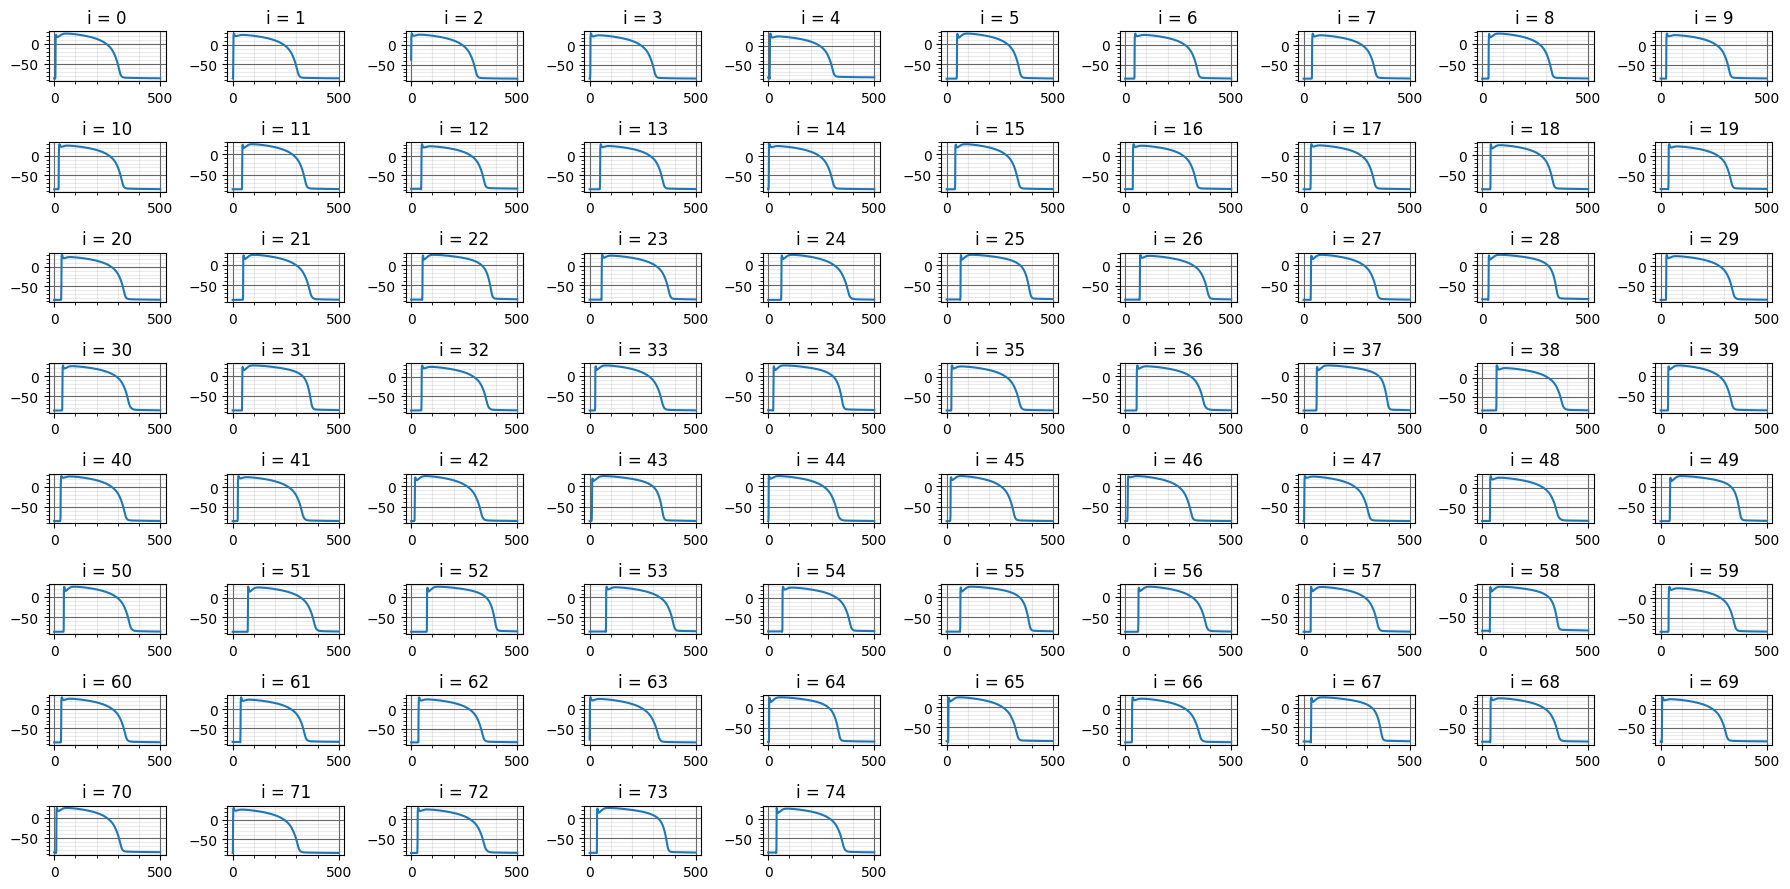

In [13]:
sample = 10
image = x_test[sample:sample+1]
decoded_imgs = model(image).numpy()
VmData = decoded_imgs[0]
row = 7
column = 10
plt.figure(figsize=(18, 9))

print(VmData.shape[1])
for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

VmData = y_test[sample]
plt.figure(figsize=(18, 9))

print(VmData.shape[1])
for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

In [14]:
model.save('t4-lstm-100.h5')